<a href="https://colab.research.google.com/github/DrUkachi/online_retail_project/blob/main/online_retail_time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Time-Series Forecasting
After the analysis of the time-Series has been performed in [this notebook](https://github.com/DrUkachi/online_retail_project/blob/main/online_retail_time_series_analysis.ipynb)

We can then confidently use some time-series algorithms to forecast the aggregated weekly sales for the next for weeks.

Several methods can be used to perform time-series, however model selection should be based on the analysis of the data.

In developing time-series models it is important to choose whether forecasts will depend only on the series itself (univariate) or whether predictions should be made on additional attributes (regressors). In this section, these two methods will be used to make the forecast.

In [2]:

!pip install pmdarima
!pip install bayesian-optimization
!pip install gluonts
!pip install mxnet

     |████████████████████████████████| 1.4 MB 9.3 MB/s 
     |████████████████████████████████| 9.8 MB 54.4 MB/s 
     |████████████████████████████████| 233 kB 75.1 MB/s 
  Attempting uninstall: patsy
    Found existing installation: patsy 0.5.1
    Uninstalling patsy-0.5.1:
      Successfully uninstalled patsy-0.5.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=59acfb19e8ff13808b220623b2d791efbee4f1c1f5716619f4ff73433d653271
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization
     |████████████████████████████████| 2.1 MB 7.0 MB/s 
     |████████████████████████████████| 10.1 MB 45.4 MB/s 
  Attempting uninstall: typing-extensions
    Found existing

In [3]:
import pickle
import warnings
from math import sqrt

import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
import tensorflow as tf
import xgboost as xgb
from bayes_opt import BayesianOptimization
from fbprophet import Prophet
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from matplotlib import pyplot as plt
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:46: UserWarning:

Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.



In [4]:
CLEANED_DATASET_PATH = "/content/drive/MyDrive/Colab_Notebooks/online_retail/further_cleaned_retail_data.csv"
cleaned_data = pd.read_csv(CLEANED_DATASET_PATH)
cleaned_data.drop(columns=['Unnamed: 0'], inplace=True)

# Generate the aggregated weekly sales
dated_retail_data = cleaned_data.copy()
dated_retail_data["Date"] = pd.to_datetime(cleaned_data["InvoiceDate"]) - pd.to_timedelta(7, unit="d")
dated_retail_data.index = dated_retail_data["Date"]
#resampling to get the weekly sales and returns
weekly_sale = dated_retail_data[dated_retail_data['Quantity']>0].Quantity.resample('W').sum()
weekly_retail = dated_retail_data[dated_retail_data['Quantity']<0].Quantity.resample('W').sum().abs()

series = weekly_sale

## Preparing the Data

In [5]:
df_series = pd.DataFrame(series)

## Defining Metrics
Metrics are used to measure the quality of predictions. To measure the accuracy of time-series forecasts, several methods exists. However, in this project there will be a focus the following metrisc:

1. **R-squred**: This is also known as the coefficient of determination and it is denoted by:

\begin{align}
        R^2 = 1 -\frac{SS_{res}} {SS_{tot}}
    \end{align}

  where,
$SS_{res}$ is the sum of squared residuals from the predicted values, and $SS_{tot}$ is the sum of squared deviations of the dependent variable from the sample mean.

2. **Mean Absolute Error**: This is the average of the absolute values of the deviation. This type of error measurement is useful when measuring prediction errors in the same unit as the original series.

\begin{align}
        MAE = \frac{\sum_{i=0}^n |y_i - \hat{y}_i|}{n}.
    \end{align}

3. **Root Mean Squared Error (RMSE)**: This is the square root of the mean of the square of all the error. TThe use of RMSE is very common, and it is considered an excellent general-purpose error metric for numerical predictions.

\begin{align}
        RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n(S_i- O_i)^2}
    \end{align}

where $O_i$ are the observations, $S_i$ predicted values of a variable, and $n$ is the number of observations avaialable for analysis. RMSE is a good measure for accuracy, but mainly used to compare prediction errors of different models or model configurations for a particular set of variable and not between variables because it is scale dependent.

4. **Mean Absolute Percentage Error**:The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in statistics. It usually expresses the accuracy as a ratio defined by the formula:

\begin{align}
        MAPE = \frac{100}{n}\sum_{i=1}^n|{\frac{A_t - F_t}{A_t}}|
    \end{align}

where $A_t$ is the actual value and $F_t$ is the forecast value. Their difference is divided by the actual value $A_t$. The absolute value in this ratio is summed for every forecasted point in time and divided by the number of fitted points $n$.





In [ ]:
import numpy as np
from sklearn.metrics import r2_score

EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """Simple error"""
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error

    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """Naive forecasting method which just repeats previous samples"""
    return actual[:-seasonality]


def _relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:], predicted[seasonality:]) / (
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
            + EPSILON
        )

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)


def _bounded_relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Bounded Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark

        abs_err = np.abs(_error(actual[seasonality:], predicted[seasonality:]))
        abs_err_bench = np.abs(
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
        )
    else:
        abs_err = np.abs(_error(actual, predicted))
        abs_err_bench = np.abs(_error(actual, benchmark))

    return abs_err / (abs_err + abs_err_bench + EPSILON)


def _geometric_mean(a, axis=0, dtype=None):
    """Geometric mean"""
    if not isinstance(a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """Mean Squared Error"""
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """Root Mean Squared Error"""
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Root Mean Squared Error"""
    return rmse(actual, predicted) / (actual.max() - actual.min())


def me(actual: np.ndarray, predicted: np.ndarray):
    """Mean Error"""
    return np.mean(_error(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """Mean Absolute Error"""
    return np.mean(np.abs(_error(actual, predicted)))


mad = mae  # Mean Absolute Deviation (it is the same as MAE)


def gmae(actual: np.ndarray, predicted: np.ndarray):
    """Geometric Mean Absolute Error"""
    return _geometric_mean(np.abs(_error(actual, predicted)))


def mdae(actual: np.ndarray, predicted: np.ndarray):
    """Median Absolute Error"""
    return np.median(np.abs(_error(actual, predicted)))


def mpe(actual: np.ndarray, predicted: np.ndarray):
    """Mean Percentage Error"""
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error

    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0

    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.mean(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def smdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Median Absolute Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.median(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))


def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error

    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )


def std_ae(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Error"""
    __mae = mae(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted) - __mae)) / (len(actual) - 1)
    )


def std_ape(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Percentage Error"""
    __mape = mape(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_percentage_error(actual, predicted) - __mape))
        / (len(actual) - 1)
    )


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def rmdspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Median Squared Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.median(np.square(_percentage_error(actual, predicted))))


def rmsse(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """Root Mean Squared Scaled Error"""
    q = np.abs(_error(actual, predicted)) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )
    return np.sqrt(np.mean(np.square(q)))


def inrse(actual: np.ndarray, predicted: np.ndarray):
    """Integral Normalized Root Squared Error"""
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted)))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def rrse(actual: np.ndarray, predicted: np.ndarray):
    """Root Relative Squared Error"""
    return np.sqrt(
        np.sum(np.square(actual - predicted))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def mre(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Error"""
    return np.mean(_relative_error(actual, predicted, benchmark))


def rae(actual: np.ndarray, predicted: np.ndarray):
    """Relative Absolute Error (aka Approximation Error)"""
    return np.sum(np.abs(actual - predicted)) / (
        np.sum(np.abs(actual - np.mean(actual))) + EPSILON
    )


def mrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Absolute Error"""
    return np.mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Median Relative Absolute Error"""
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))


def gmrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Geometric Mean Relative Absolute Error"""
    return _geometric_mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Bounded Relative Absolute Error"""
    return np.mean(_bounded_relative_error(actual, predicted, benchmark))


def umbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Unscaled Mean Bounded Relative Absolute Error"""
    __mbrae = mbrae(actual, predicted, benchmark)
    return __mbrae / (1 - __mbrae)


def mda(actual: np.ndarray, predicted: np.ndarray):
    """Mean Directional Accuracy"""
    return np.mean(
        (
            np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])
        ).astype(int)
    )


def bias(actual: np.ndarray, predicted: np.ndarray):
    """Mean forecast error(or Forecast Bias)"""
    return np.mean(actual - predicted)


METRICS = {
    "mse": mse,
    "rmse": rmse,
    "nrmse": nrmse,
    "me": me,
    "mae": mae,
    "mad": mad,
    "gmae": gmae,
    "mdae": mdae,
    "mpe": mpe,
    "mape": mape,
    "mdape": mdape,
    "smape": smape,
    "smdape": smdape,
    "maape": maape,
    "mase": mase,
    "std_ae": std_ae,
    "std_ape": std_ape,
    "rmspe": rmspe,
    "rmdspe": rmdspe,
    "rmsse": rmsse,
    "inrse": inrse,
    "rrse": rrse,
    "mre": mre,
    "rae": rae,
    "mrae": mrae,
    "mdrae": mdrae,
    "gmrae": gmrae,
    "mbrae": mbrae,
    "umbrae": umbrae,
    "mda": mda,
    "bias": bias,
    "r2": r2_score,
}


def evaluate(
    actual: np.ndarray, predicted: np.ndarray, 
    metrics=("mae", "rmse", "mape", "r2")
):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results


def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))

In [ ]:
resultsDict = {}
predictionsDict = {}

SPLIT_DATE = '2011-11-06'
train_df = df_series.loc[df_series.index <= SPLIT_DATE]
test_df = df_series.loc[df_series.index > SPLIT_DATE]
print(f"{len(train_df)} weeks of train data \n {len(test_df)} weeks of test data")

102 weeks of train data 
 4 weeks of test data


In [ ]:
# Baseline Model
mean = train_df.Quantity.mean()
mean = np.array([mean for u in range(len(test_df))])
resultsDict['Naive mean'] = evaluate(test_df.Quantity, mean)
predictionsDict['Naive mean'] = mean


## Univariate Time Series Analysis
In this section time-series forecasting methods that only look at the target variable will be used.

### Method 1: The Simple Exponential Smoothing

This method models the next time step as an exponentially weighted linear function of observations at prior time steps

In [ ]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(train_df)
yhat = list()
for t in tqdm(range(len(test_df.Quantity))):
    temp_train = df_series[:len(train_df)+t]
    model = SimpleExpSmoothing(temp_train.Quantity)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(test_df.Quantity, yhat.values)
predictionsDict['SES'] = yhat.values

100%|██████████| 4/4 [00:00<00:00, 85.48it/s]


In [ ]:
resultsDict

{'Naive mean': {'mae': 64380.63725490196,
  'mape': 0.40404962183236276,
  'r2': -23.833941831061757,
  'rmse': 65717.36828150737},
 'SES': {'mae': 13697.959852637745,
  'mape': 0.08706640386845278,
  'r2': -0.4372433819644075,
  'rmse': 15809.658623520598}}

### Holt Winter’s Exponential Smoothing (HWES)

Description: 

In [ ]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(train_df)
yhat = list()
for t in tqdm(range(len(test_df.Quantity))):
    temp_train = df_series[:len(train_df)+t]
    model = ExponentialSmoothing(temp_train.Quantity)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(test_df.Quantity, yhat.values)
predictionsDict['HWES'] = yhat.values

100%|██████████| 4/4 [00:00<00:00, 121.18it/s]


### Autoregression (AR)
The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps. Parameters of the model:

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

In [ ]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(train_df)
yhat = list()
for t in tqdm(range(len(test_df.Quantity))):
    temp_train = df_series[:len(train_df)+t]
    model = AR(temp_train.Quantity)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train),
                                    dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AR'] = evaluate(test_df.Quantity, yhat.values)
predictionsDict['AR'] = yhat.values

100%|██████████| 4/4 [00:00<00:00, 90.13it/s]


In [ ]:
resultsDict

{'AR': {'mae': 21274.449418795593,
  'mape': 0.13224040117406527,
  'r2': -1.8812488878038707,
  'rmse': 22384.516652655242},
 'HWES': {'mae': 13697.959852637745,
  'mape': 0.08706640386845278,
  'r2': -0.4372433819644075,
  'rmse': 15809.658623520598},
 'Naive mean': {'mae': 64380.63725490196,
  'mape': 0.40404962183236276,
  'r2': -23.833941831061757,
  'rmse': 65717.36828150737},
 'SES': {'mae': 13697.959852637745,
  'mape': 0.08706640386845278,
  'r2': -0.4372433819644075,
  'rmse': 15809.658623520598}}

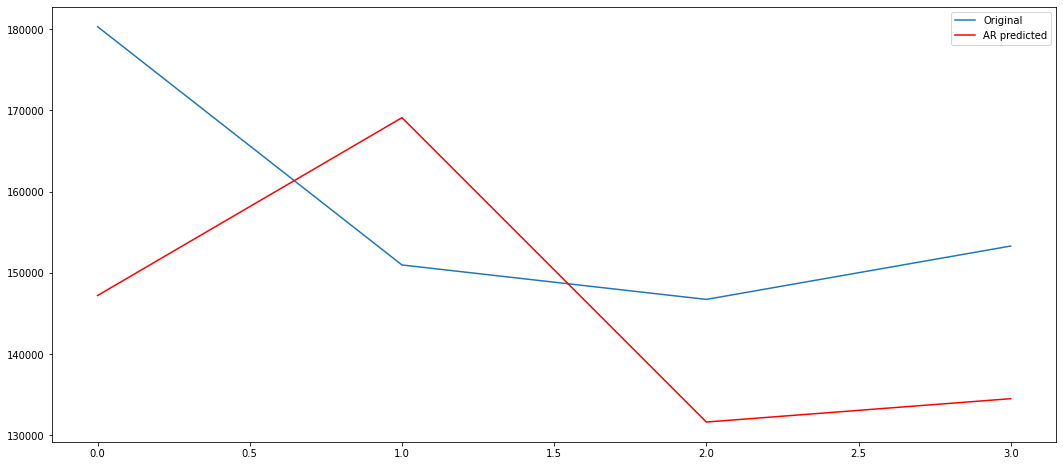

In [ ]:
plt.plot(test_df.Quantity.values, label='Original')
plt.plot(yhat.values, color='red', label='AR predicted')
plt.legend()

In [ ]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(train_df)
yhat = list()
for t in tqdm(range(len(test_df.Quantity))):
  print(t)

100%|██████████| 4/4 [00:00<00:00, 1292.74it/s]

0
1
2
3


## Moving Average (MA)

The Moving Average (MA) method models the next step in the sequence as the average of a window of observations at prior time steps. Parameters of the model:

Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

In [ ]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(train_df)
yhat = list()
for t in tqdm(range(len(test_df.Quantity))):
    temp_train = df_series[:len(train_df)+t]
    model = ARMA(temp_train.Quantity, order=(0,1))
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train),
                                    dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['MA'] = evaluate(test_df.Quantity, yhat.values)
predictionsDict['MA'] = yhat.values

100%|██████████| 4/4 [00:00<00:00, 21.81it/s]


In [ ]:
resultsDict

{'AR': {'mae': 21274.449418795593,
  'mape': 0.13224040117406527,
  'r2': -1.8812488878038707,
  'rmse': 22384.516652655242},
 'HWES': {'mae': 13697.959852637745,
  'mape': 0.08706640386845278,
  'r2': -0.4372433819644075,
  'rmse': 15809.658623520598},
 'MA': {'mae': 39521.41047490899,
  'mape': 0.24710985372592503,
  'r2': -8.765039332636457,
  'rmse': 41209.21408696808},
 'Naive mean': {'mae': 64380.63725490196,
  'mape': 0.40404962183236276,
  'r2': -23.833941831061757,
  'rmse': 65717.36828150737},
 'SES': {'mae': 13697.959852637745,
  'mape': 0.08706640386845278,
  'r2': -0.4372433819644075,
  'rmse': 15809.658623520598}}

In [ ]:
def plot_ma_values(column_name, yhat, title):
  predicted_dates = list(range(2040, 2056,2))
  fig, ax = plt.subplots()
  plt.plot(test_df[column_name].values, label='Original')
  plt.plot(yhat.values, color='red', label='MA predicted')
  plt.title(f'Moving Average Forecast For {title}')
  plt.ylabel("Quantity")
  plt.xlabel("Week")
  ax.set_xticklabels(predicted_dates, rotation=90)
  plt.legend();
  plt.savefig(f"{FOLDER_PATH}{title}_moving_average")

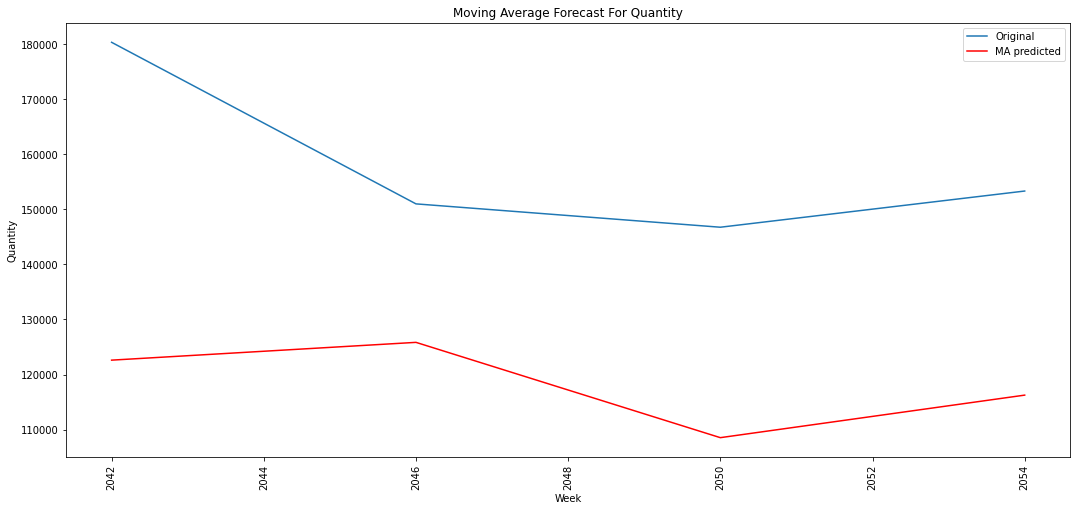

In [ ]:
plot_ma_values("Quantity", yhat, "Quantity")

### Autoregressive Moving Average (ARMA)

This method will basically join the previous two `AR` and `MA`. Model parameters will be the sum of the two.

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.



In [ ]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(train_df)
yhat = list()
for t in tqdm(range(len(test_df.Quantity))):
    temp_train = df_series[:len(train_df)+t]
    model = ARMA(temp_train.Quantity, order=(1,1))
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train),
                                    dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['ARMA'] = evaluate(test_df.Quantity, yhat.values)
predictionsDict['ARMA'] = yhat.values

100%|██████████| 4/4 [00:00<00:00,  8.62it/s]


In [ ]:
resultsDict

{'AR': {'mae': 21274.449418795593,
  'mape': 0.13224040117406527,
  'r2': -1.8812488878038707,
  'rmse': 22384.516652655242},
 'ARMA': {'mae': 17967.872025480618,
  'mape': 0.11018538935044533,
  'r2': -1.5848853412068404,
  'rmse': 21202.055910589734},
 'HWES': {'mae': 13697.959852637745,
  'mape': 0.08706640386845278,
  'r2': -0.4372433819644075,
  'rmse': 15809.658623520598},
 'MA': {'mae': 39521.41047490899,
  'mape': 0.24710985372592503,
  'r2': -8.765039332636457,
  'rmse': 41209.21408696808},
 'Naive mean': {'mae': 64380.63725490196,
  'mape': 0.40404962183236276,
  'r2': -23.833941831061757,
  'rmse': 65717.36828150737},
 'SES': {'mae': 13697.959852637745,
  'mape': 0.08706640386845278,
  'r2': -0.4372433819644075,
  'rmse': 15809.658623520598}}

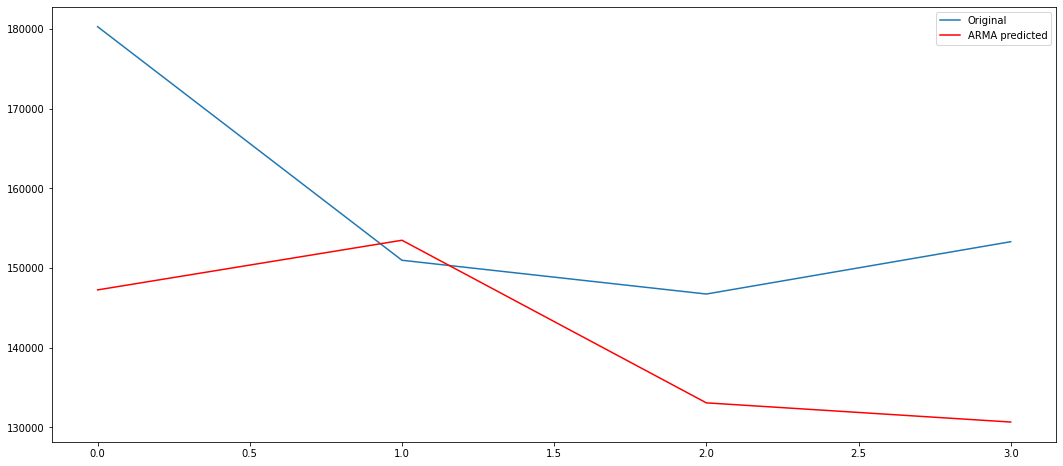

In [ ]:
plt.plot(test_df.Quantity.values, label='Original')
plt.plot(yhat.values, color='red', label='ARMA predicted')
plt.legend()

### Autoregressive integrated moving average (ARIMA)

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

* Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
* Number of Differences (d): d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
* Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

**Tuning ARIMA parameters**

Non stationarity series will require level of differencing (d) >0 in ARIMA
Select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots
AUTOARIMA

Note: A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

In [ ]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(train_df)
yhat = list()
for t in tqdm(range(len(test_df.Quantity))):
    temp_train = df_series[:len(train_df)+t]
    model = ARIMA(temp_train.Quantity, order=(1,0,0))
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train),
                                    dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(test_df.Quantity, yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████| 4/4 [00:00<00:00, 31.14it/s]


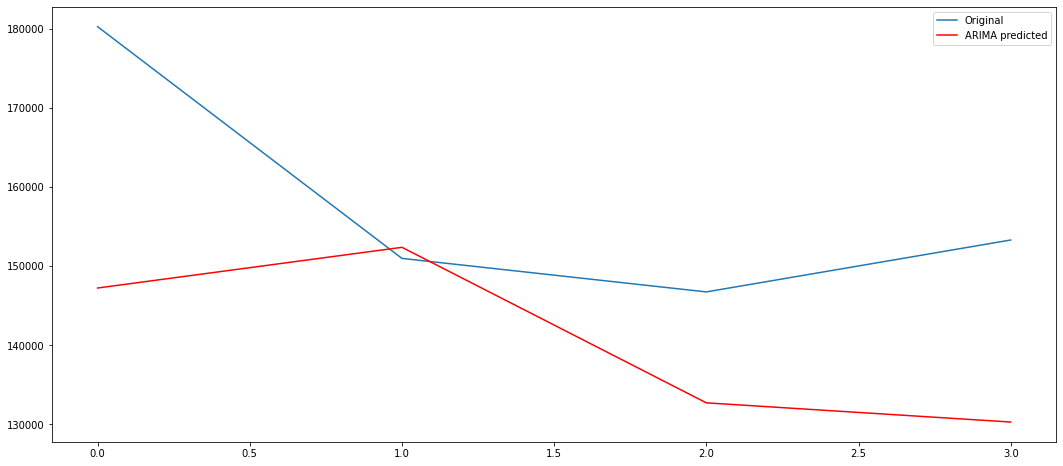

In [ ]:
plt.plot(test_df.Quantity.values, label='Original')
plt.plot(yhat.values, color='red', label='ARIMA predicted')
plt.legend()

In [ ]:
resultsDict

{'AR': {'mae': 21274.449418795593,
  'mape': 0.13224040117406527,
  'r2': -1.8812488878038707,
  'rmse': 22384.516652655242},
 'ARIMA': {'mae': 17889.69493700406,
  'mape': 0.10966924216063507,
  'r2': -1.621837191433773,
  'rmse': 21353.06359279361},
 'ARMA': {'mae': 17967.872025480618,
  'mape': 0.11018538935044533,
  'r2': -1.5848853412068404,
  'rmse': 21202.055910589734},
 'HWES': {'mae': 13697.959852637745,
  'mape': 0.08706640386845278,
  'r2': -0.4372433819644075,
  'rmse': 15809.658623520598},
 'MA': {'mae': 39521.41047490899,
  'mape': 0.24710985372592503,
  'r2': -8.765039332636457,
  'rmse': 41209.21408696808},
 'Naive mean': {'mae': 64380.63725490196,
  'mape': 0.40404962183236276,
  'r2': -23.833941831061757,
  'rmse': 65717.36828150737},
 'SES': {'mae': 13697.959852637745,
  'mape': 0.08706640386845278,
  'r2': -0.4372433819644075,
  'rmse': 15809.658623520598}}

In [ ]:
# building the model

autoModel = pm.auto_arima(train_df.Quantity, trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=False)
autoModel.fit(train_df.Quantity)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2395.148, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2640.672, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2400.379, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2577.063, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2394.249, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2565.258, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2398.044, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2395.026, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2562.622, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2388.318, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2393.946, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2385.955, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2

ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [ ]:
order = autoModel.order
yhat = list()
for t in tqdm(range(len(test_df.Quantity))):
    temp_train = df_series[:len(train_df.Quantity)+t]
    model = ARIMA(temp_train.Quantity, order=order)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoARIMA {0}'.format(order)] = evaluate(
    test_df.Quantity, yhat)
predictionsDict['AutoARIMA {0}'.format(order)] = yhat.values

100%|██████████| 4/4 [00:00<00:00, 41.13it/s]


In [ ]:
resultsDict

{'AR': {'mae': 21274.449418795593,
  'mape': 0.13224040117406527,
  'r2': -1.8812488878038707,
  'rmse': 22384.516652655242},
 'ARIMA': {'mae': 17889.69493700406,
  'mape': 0.10966924216063507,
  'r2': -1.621837191433773,
  'rmse': 21353.06359279361},
 'ARMA': {'mae': 17967.872025480618,
  'mape': 0.11018538935044533,
  'r2': -1.5848853412068404,
  'rmse': 21202.055910589734},
 'AutoARIMA (1, 0, 0)': {'mae': 17889.69493700406,
  'mape': 0.10966924216063507,
  'r2': -1.621837191433773,
  'rmse': 21353.06359279361},
 'HWES': {'mae': 13697.959852637745,
  'mape': 0.08706640386845278,
  'r2': -0.4372433819644075,
  'rmse': 15809.658623520598},
 'MA': {'mae': 39521.41047490899,
  'mape': 0.24710985372592503,
  'r2': -8.765039332636457,
  'rmse': 41209.21408696808},
 'Naive mean': {'mae': 64380.63725490196,
  'mape': 0.40404962183236276,
  'r2': -23.833941831061757,
  'rmse': 65717.36828150737},
 'SES': {'mae': 13697.959852637745,
  'mape': 0.08706640386845278,
  'r2': -0.4372433819644075,
 

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)
Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

__Trend Elements:__

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

__Seasonal Elements:__

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.

__SARIMA notation:__
SARIMA(p,d,q)(P,D,Q,m)

In [ ]:
# SARIMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(test_df)
yhat = list()
for t in tqdm(range(len(test_df.Quantity))):
    temp_train = df_series[:len(test_df)+t]
    model = SARIMAX(temp_train.Quantity, order=(
        1, 0, 0), seasonal_order=(0, 0, 0, 12)) # changed from 3 to 1
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SARIMAX'] = evaluate(test_df.Quantity, yhat.values)
predictionsDict['SARIMAX'] = yhat.values

100%|██████████| 4/4 [00:00<00:00, 48.86it/s]


In [ ]:
resultsDict

{'AR': {'mae': 21274.449418795593,
  'mape': 0.13224040117406527,
  'r2': -1.8812488878038707,
  'rmse': 22384.516652655242},
 'ARIMA': {'mae': 17889.69493700406,
  'mape': 0.10966924216063507,
  'r2': -1.621837191433773,
  'rmse': 21353.06359279361},
 'ARMA': {'mae': 17967.872025480618,
  'mape': 0.11018538935044533,
  'r2': -1.5848853412068404,
  'rmse': 21202.055910589734},
 'AutoARIMA (1, 0, 0)': {'mae': 17889.69493700406,
  'mape': 0.10966924216063507,
  'r2': -1.621837191433773,
  'rmse': 21353.06359279361},
 'HWES': {'mae': 13697.959852637745,
  'mape': 0.08706640386845278,
  'r2': -0.4372433819644075,
  'rmse': 15809.658623520598},
 'MA': {'mae': 39521.41047490899,
  'mape': 0.24710985372592503,
  'r2': -8.765039332636457,
  'rmse': 41209.21408696808},
 'Naive mean': {'mae': 64380.63725490196,
  'mape': 0.40404962183236276,
  'r2': -23.833941831061757,
  'rmse': 65717.36828150737},
 'SARIMAX': {'mae': 118119.60387865943,
  'mape': 0.7410413763825117,
  'r2': -87.03955029657169,

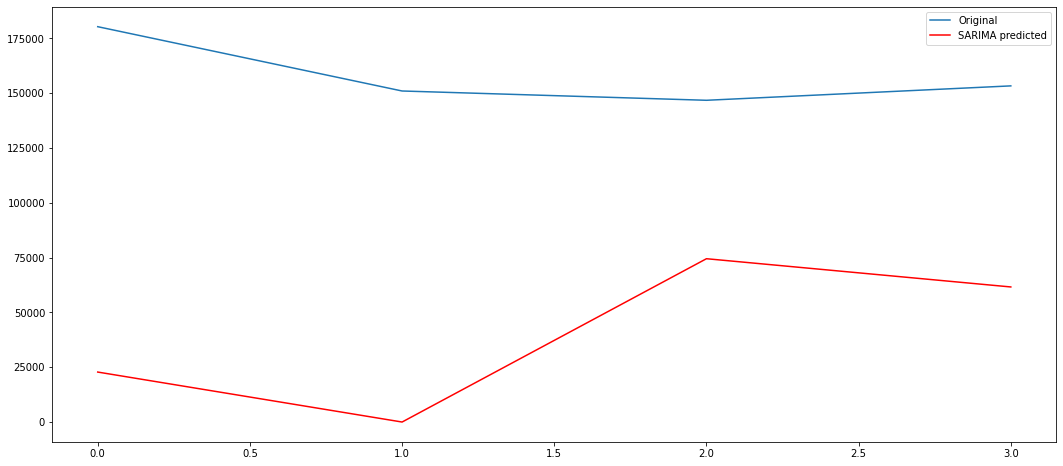

In [ ]:
plt.plot(test_df.Quantity.values, label='Original')
plt.plot(yhat.values, color='red', label='SARIMA predicted')
plt.legend()

In [ ]:
# building the model
autoModel = pm.auto_arima(train_df.Quantity, trace=True, error_action='ignore',
                          suppress_warnings=True, seasonal=True, m=2, stepwise=True)
autoModel.fit(train_df.Quantity)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=2390.260, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=2435.648, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=2385.475, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=2394.505, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=2640.672, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=2383.578, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=2385.480, Time=0.06 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=2385.955, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=2401.899, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=2400.379, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[2] intercept
Total fit time: 0.993 seconds


ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 2),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [ ]:
order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in tqdm(range(len(test_df.Quantity))):
    temp_train = df_series[:len(train_df)+t]
    model = SARIMAX(train_df.Quantity, order=order,
                    seasonal_order=seasonalOrder)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoSARIMAX {0},{1}'.format(order, seasonalOrder)] = evaluate(
    test_df.Quantity, yhat.values)
predictionsDict['AutoSARIMAX {0},{1}'.format(
    order, seasonalOrder)] = yhat.values

100%|██████████| 4/4 [00:00<00:00, 37.38it/s]


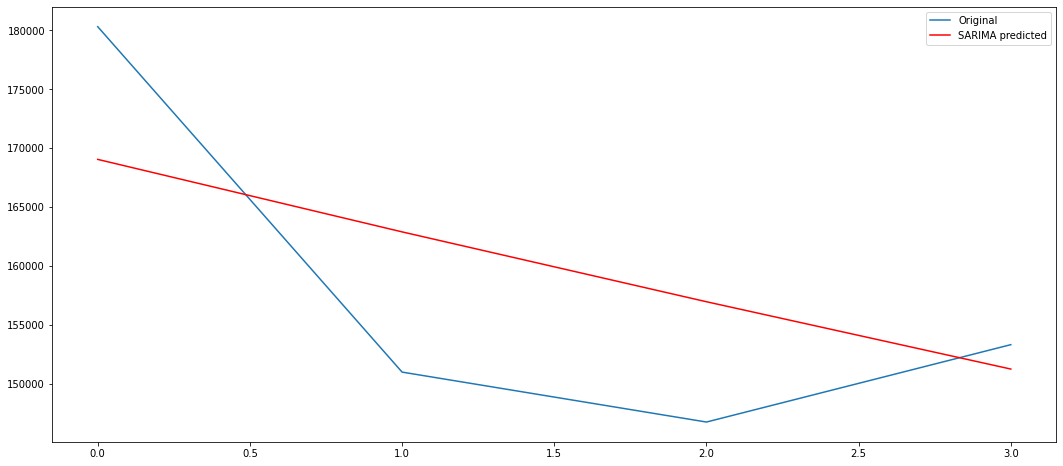

In [ ]:
plt.plot(test_df.Quantity.values, label='Original')
plt.plot(yhat.values, color='red', label='SARIMA predicted')
plt.legend()

In [ ]:
yhat.values

array([169048.7729616 , 162893.16187476, 156961.69644238, 151246.21479822])

### Prophet

Prophet is a model released by [Facebook](https://github.com/facebook/prophet). Is essentially a curve fitting approach, very similar in spirit to how BSTS models trend and seasonality, except that it uses generalized additive models instead of a state-space representation to describe each component.


In [ ]:
# Prophet needs some specifics data stuff, coment it here
prophet_training = train_df.rename(
    columns={'Quantity': 'y'})  # old method
prophet_training['ds'] = prophet_training.index
prophet_training.index = pd.RangeIndex(len(prophet_training.index))

prophet_test = test_df.rename(columns={'Quantity': 'y'})  # old method
prophet_test['ds'] = prophet_test.index
prophet_test.index = pd.RangeIndex(len(prophet_test.index))

In [ ]:
prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    holidays_prior_scale=20,
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False
).add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=55
).add_seasonality(
    name='daily',
    period=1,
    fourier_order=15
).add_seasonality(
    name='weekly',
    period=7,
    fourier_order=25
).add_seasonality(
    name='yearly',
    period=365.25,
    fourier_order=20
).add_seasonality(
    name='quarterly',
    period=365.25/4,
    fourier_order=55
).add_country_holidays(country_name='UK')

In [ ]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet univariate'] = evaluate(
    test_df.Quantity, yhat.yhat.values)
predictionsDict['Prophet univariate'] = yhat.yhat.values

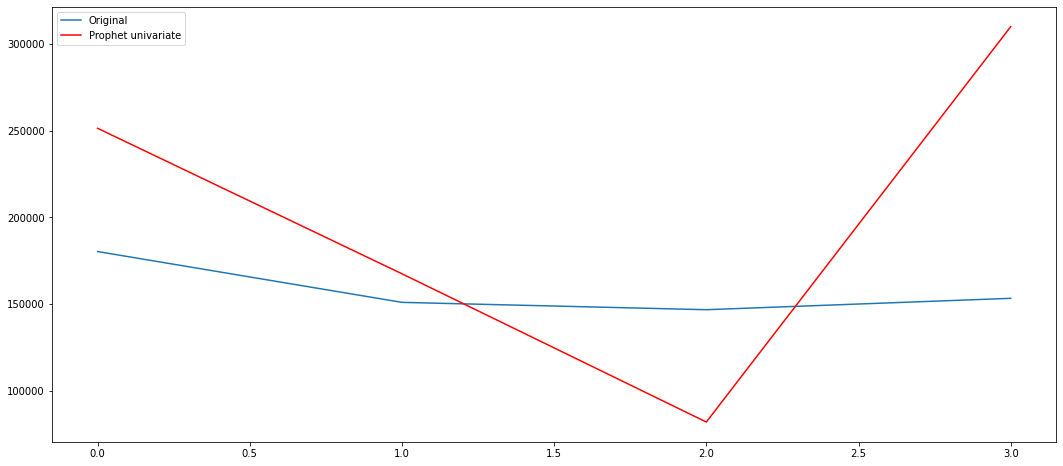

In [ ]:
plt.plot(test_df.Quantity.values, label='Original')
plt.plot(yhat.yhat, color='red', label='Prophet univariate')
plt.legend()

## Multivariate Time Series Forecasting
A Multivariate time series has more than one time-dependent variable. Each variable depends not only on its past values but also has some dependency on other variables. This dependency is used for forecasting future values.

## Method 1: Using Time Features

In [ ]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [ ]:
train_df

,Quantity,date,hour,dayofweek,quarter,month,year,dayofyear,sin_day,cos_day,dayofmonth,weekofyear
Date,,,,,,,,,,,,
2009-11-29,125490,2009-11-29,0,6,4,11,2009,333,-0.008821,0.999961,29,48
2009-12-06,110066,2009-12-06,0,6,4,12,2009,340,0.650311,0.759668,6,49
2009-12-13,129763,2009-12-13,0,6,4,12,2009,347,0.989363,0.145470,13,50
2009-12-20,27014,2009-12-20,0,6,4,12,2009,354,0.841455,-0.540328,20,51
2009-12-27,0,2009-12-27,0,6,4,12,2009,361,0.279387,-0.960179,27,52
...,...,...,...,...,...,...,...,...,...,...,...,...
2011-10-09,114600,2011-10-09,0,6,4,10,2011,282,-0.676750,0.736213,9,40
2011-10-16,146799,2011-10-16,0,6,4,10,2011,289,-0.026521,0.999648,16,41
2011-10-23,134407,2011-10-23,0,6,4,10,2011,296,0.636761,0.771061,23,42


In [ ]:
X_train_df, y_train = create_time_features(
    train_df, target='Quantity')

X_test_df, y_test = create_time_features(test_df, target='Quantity')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

## Using Linear Models

### Linear Model Algorithm 1: Bayesian Regression

In [ ]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['BayesianRidge'] = evaluate(test_df.Quantity, yhat)
predictionsDict['BayesianRidge'] = yhat

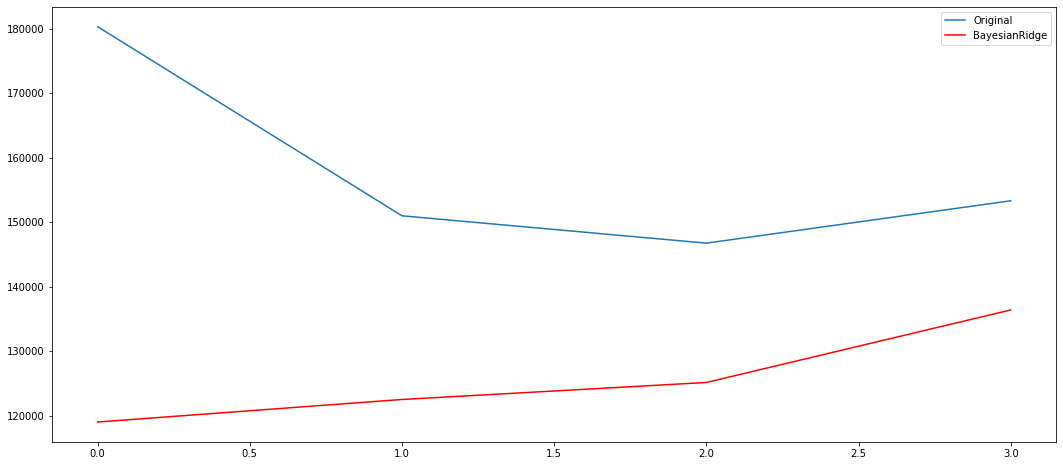

In [ ]:
plt.plot(test_df.Quantity.values, label='Original')
plt.plot(yhat, color='red', label='BayesianRidge')
plt.legend()

### Linear Model Algorithm 2: Lasso

In [ ]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Lasso'] = evaluate(test_df.Quantity, yhat)
predictionsDict['Lasso'] = yhat

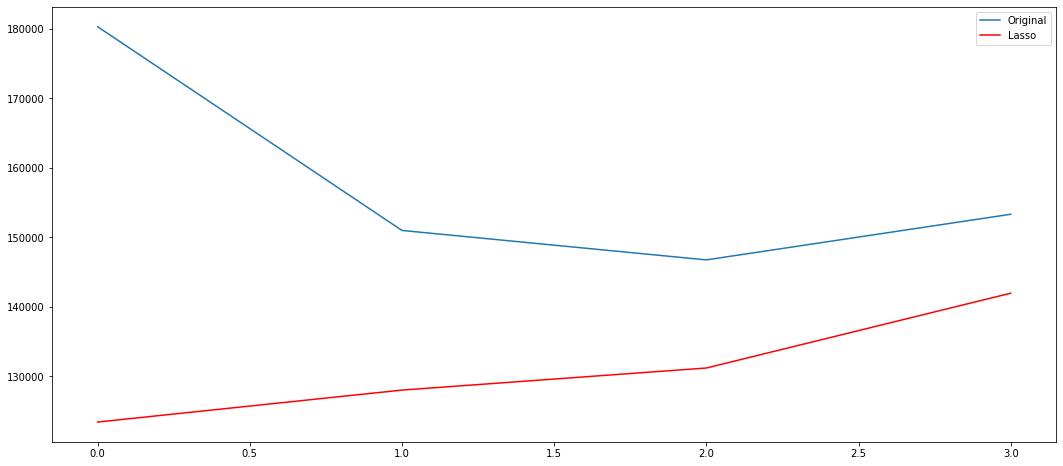

In [ ]:
plt.plot(test_df.Quantity.values, label='Original')
plt.plot(yhat, color='red', label='Lasso')
plt.legend()

## Using Tree Models

### RandomForest

In [ ]:
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(test_df.Quantity, yhat)
predictionsDict['Randomforest'] = yhat

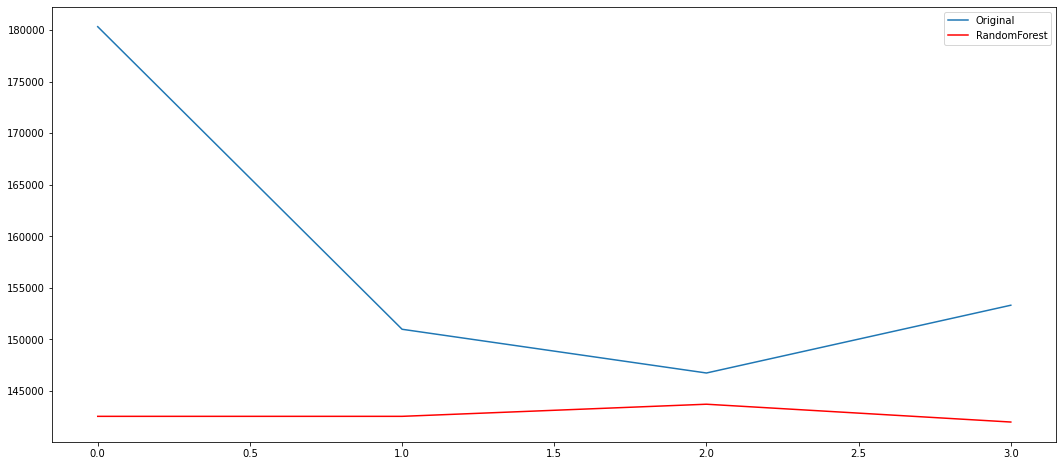

In [ ]:
plt.plot(test_df.Quantity.values, label='Original')
plt.plot(yhat, color='red', label='RandomForest')
plt.legend()

### XGBoost

In [ ]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(test_df.Quantity, yhat)
predictionsDict['XGBoost'] = yhat

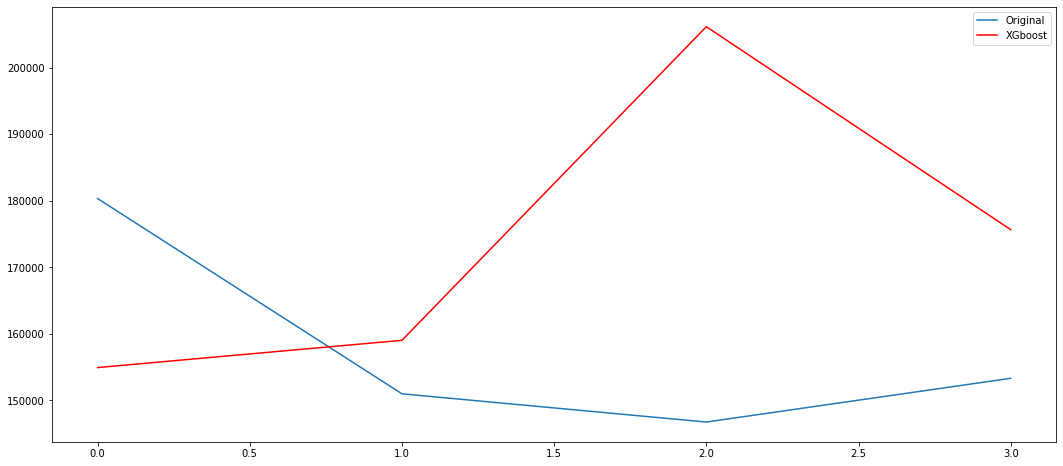

In [ ]:
plt.plot(test_df.Quantity.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

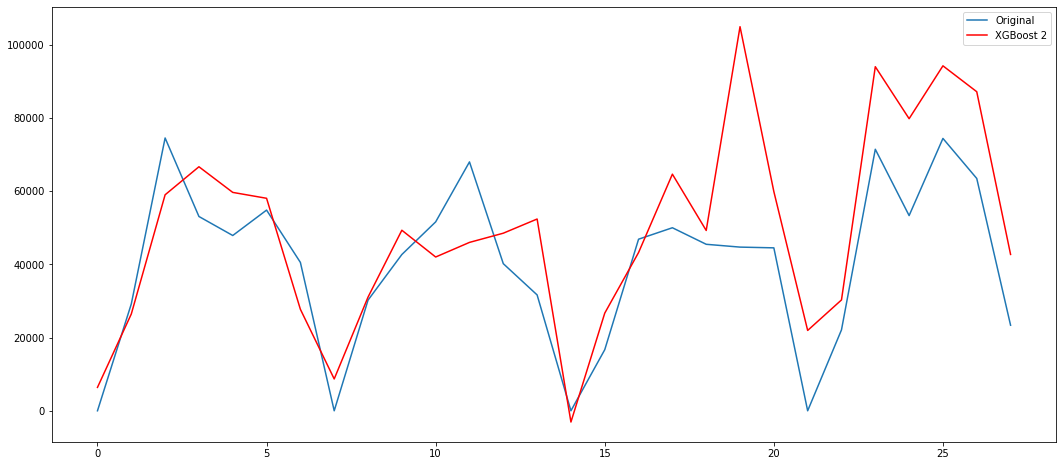

In [ ]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['XGBoost 2'] = evaluate(df_test.Amount_Spent, yhat)
predictionsDict['XGBoost 2'] = yhat

plt.plot(df_test.Amount_Spent.values, label='Original')
plt.plot(yhat, color='red', label='XGBoost 2')
plt.legend()

### LightGBM - 

A tree gradient boosting model by [Microsoft](https://github.com/microsoft/LightGBM)

In [ ]:
def use_model(model, name):
  model.fit(X_train, y_train)
  y_hat = model.predict(X_test)
  resultsDict[name] = evaluate(test_df.Quantity, yhat)
  predictionsDict[name] = yhat

  # To visualize the results
  plt.plot(test_df.Quantity.values, label='Original')
  plt.plot(yhat, color='red', label=name)
  plt.legend()

  return resultsDict[name], predictionsDict[name]


In [ ]:
X_train.shape

(711, 10)

In [ ]:
X_test.shape

(28, 10)

In [ ]:
df_training.shape

(711, 12)

In [ ]:
df_test.shape

(28, 12)

In [ ]:
df_test.columns

Index(['Amount_Spent', 'date', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'sin_day', 'cos_day', 'dayofmonth', 'weekofyear'],
      dtype='object')

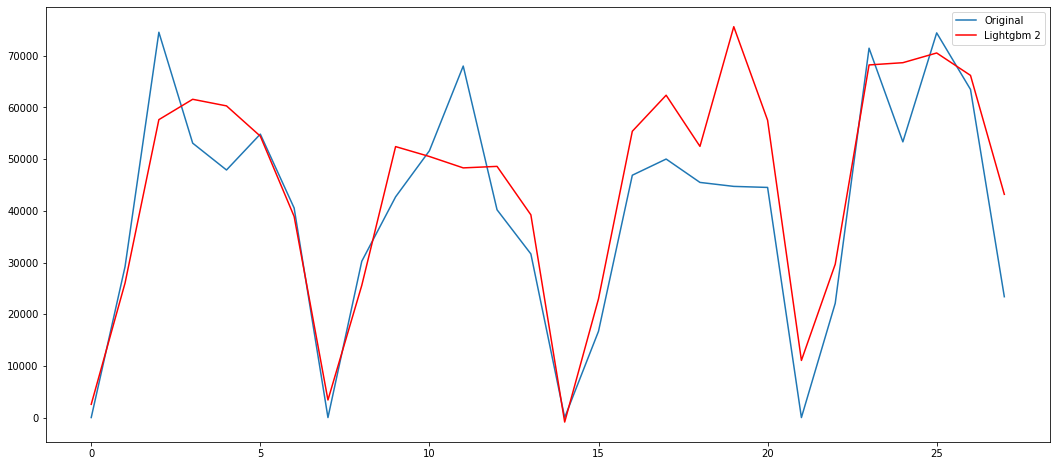

In [ ]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train, y_train)
yhat = lightGBM.predict(X_test)
resultsDict['Lightgbm 2'] = evaluate(df_test.Amount_Spent, yhat)
predictionsDict['Lightgbm 2'] = yhat

plt.plot(df_test.Amount_Spent.values, label='Original')
plt.plot(yhat, color='red', label='Lightgbm 2')
plt.legend()

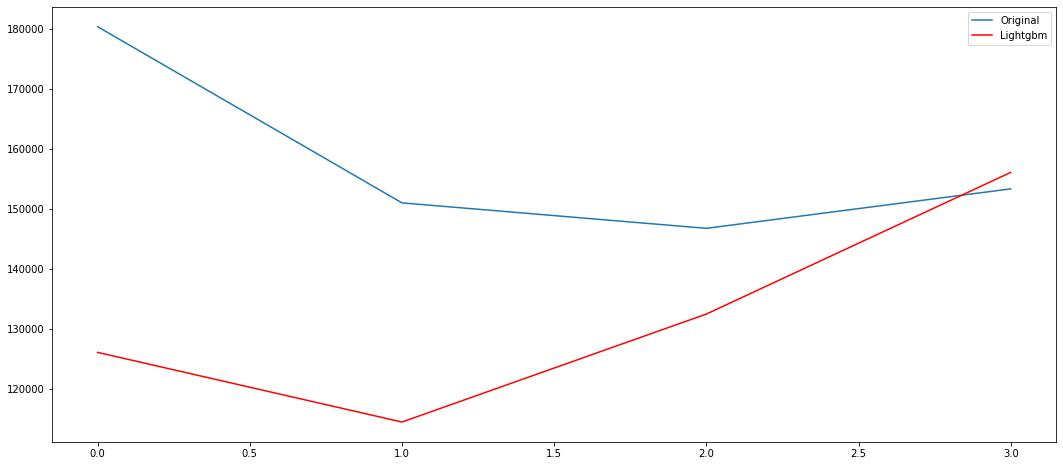

In [ ]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train, y_train)
yhat = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(test_df.Quantity, yhat)
predictionsDict['Lightgbm'] = yhat

plt.plot(test_df.Quantity.values, label='Original')
plt.plot(yhat, color='red', label='Lightgbm')
plt.legend()


### Support vector machines

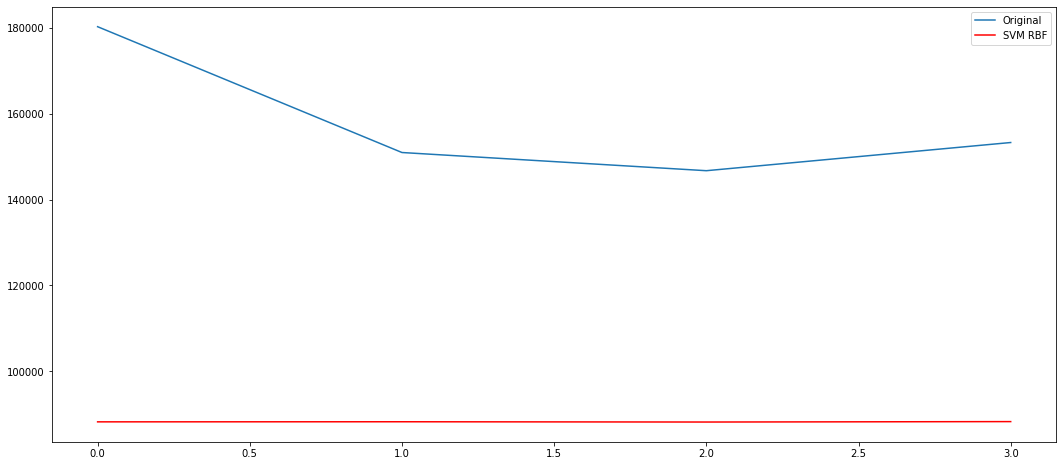

In [ ]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF'] = evaluate(test_df.Quantity, yhat)
predictionsDict['SVM RBF'] = yhat

plt.plot(test_df.Quantity.values, label='Original')
plt.plot(yhat, color='red', label='SVM RBF')
plt.legend()

## Using Nearest Neighbours


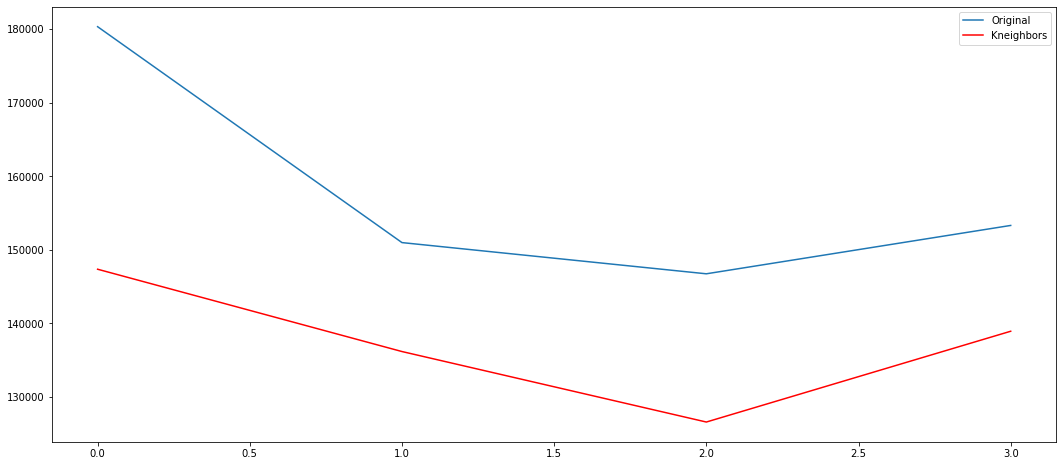

In [ ]:
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Kneighbors'] = evaluate(test_df.Quantity, yhat)
predictionsDict['Kneighbors'] = yhat

plt.plot(test_df.Quantity.values, label='Original')
plt.plot(yhat, color='red', label='Kneighbors')
plt.legend()

### Prophet Multivariate

In [ ]:
prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    daily_seasonality=True,
).add_country_holidays(country_name='UK')


for col in prophet_training.columns:
    if col not in ["ds", "y"]:
        prophet.add_regressor(col)

In [ ]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet multivariate'] = evaluate(y_test, yhat.yhat.values)
predictionsDict['Prophet multivariate'] = yhat.yhat.values

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


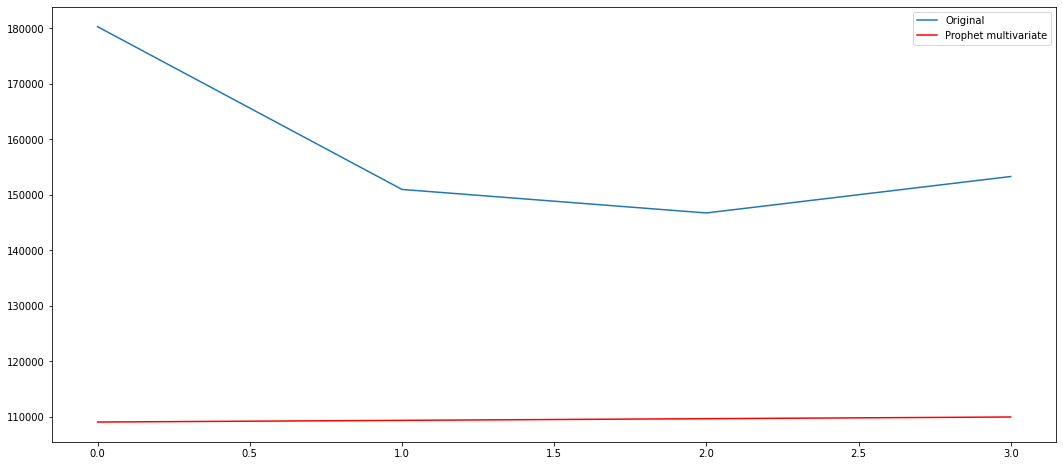

In [ ]:
plt.plot(test_df.Quantity.values, label='Original')
plt.plot(yhat.yhat, color='red', label='Prophet multivariate')
plt.legend()

In [ ]:
cleaned_data.index = cleaned_data["InvoiceDate"]

## Deep Learning

In [ ]:
cleaned_data["Date"] = pd.to_datetime(cleaned_data["Date"])
cleaned_data.index = cleaned_data["Date"]

daily_sales = cleaned_data['Amount_Spent'].resample('D').sum()

In [ ]:
split_date = '2011-11-11' # Predict for 28 days
df_training = daily_sales.loc[daily_sales.index <= split_date]
df_test = daily_sales.loc[daily_sales.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

711 days of training data 
 28 days of testing data 


In [ ]:
df_training = pd.DataFrame(df_training)
df_test = pd.DataFrame(df_test)

In [ ]:
# ADD time features to our model
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [ ]:
train_df

,Quantity,date,hour,dayofweek,quarter,month,year,dayofyear,sin_day,cos_day,dayofmonth,weekofyear
Date,,,,,,,,,,,,
2009-11-29,125490,2009-11-29,0,6,4,11,2009,333,-0.008821,0.999961,29,48
2009-12-06,110066,2009-12-06,0,6,4,12,2009,340,0.650311,0.759668,6,49
2009-12-13,129763,2009-12-13,0,6,4,12,2009,347,0.989363,0.145470,13,50
2009-12-20,27014,2009-12-20,0,6,4,12,2009,354,0.841455,-0.540328,20,51
2009-12-27,0,2009-12-27,0,6,4,12,2009,361,0.279387,-0.960179,27,52
...,...,...,...,...,...,...,...,...,...,...,...,...
2011-10-09,114600,2011-10-09,0,6,4,10,2011,282,-0.676750,0.736213,9,40
2011-10-16,146799,2011-10-16,0,6,4,10,2011,289,-0.026521,0.999648,16,41
2011-10-23,134407,2011-10-23,0,6,4,10,2011,296,0.636761,0.771061,23,42


In [ ]:
# Transforming the data for Deep Learning
# X_train_df, y_train = create_time_features(
#     df_training, target='Amount_Spent')
# X_test_df, y_test = create_time_features(df_test, target='Amount_Spent')
# scaler = StandardScaler()
# scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
# X_train = scaler.transform(X_train_df)
# X_test = scaler.transform(X_test_df)

# X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
# X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

In [ ]:
# For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24


def window_data(X, Y, window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)


# Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

# Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [ ]:
dropout = 0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='rmsprop', loss='mae')

# logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S") #Support for tensorboard tracking!
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)  # ,callbacks=[tensorboard_callback]) #Uncomment this line for tensorboard support

Epoch 1/10
200/200 [==============================] - 10s 38ms/step - loss: 82932.2812 - val_loss: 110427.6797
Epoch 2/10
200/200 [==============================] - 7s 35ms/step - loss: 29519.6660 - val_loss: 35150.7500
Epoch 3/10
200/200 [==============================] - 7s 35ms/step - loss: 15250.6123 - val_loss: 10522.5010
Epoch 4/10
200/200 [==============================] - 7s 35ms/step - loss: 11866.7842 - val_loss: 15533.8975
Epoch 5/10
200/200 [==============================] - 7s 35ms/step - loss: 10256.7734 - val_loss: 18136.9844
Epoch 6/10
200/200 [==============================] - 7s 35ms/step - loss: 8936.1025 - val_loss: 19302.3711
Epoch 7/10
200/200 [==============================] - 7s 35ms/step - loss: 7512.0142 - val_loss: 19814.7520
Epoch 8/10
200/200 [==============================] - 7s 34ms/step - loss: 6304.7261 - val_loss: 24064.0117
Epoch 9/10
200/200 [==============================] - 7s 34ms/step - loss: 5556.5308 - val_loss: 20520.6406
Epoch 10/10
200/200 [

In [ ]:
yhat = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]
resultsDict['Tensorflow simple LSTM'] = evaluate(y_test, yhat)
predictionsDict['Tensorflow simple LSTM'] = yhat

In [ ]:
resultsDict

{'AR': {'mae': 21274.449418795593,
  'mape': 0.13224040117406527,
  'r2': -1.8812488878038707,
  'rmse': 22384.516652655242},
 'ARIMA': {'mae': 17889.69493700406,
  'mape': 0.10966924216063507,
  'r2': -1.621837191433773,
  'rmse': 21353.06359279361},
 'ARMA': {'mae': 17967.872025480618,
  'mape': 0.11018538935044533,
  'r2': -1.5848853412068404,
  'rmse': 21202.055910589734},
 'AutoARIMA (1, 0, 0)': {'mae': 17889.69493700406,
  'mape': 0.10966924216063507,
  'r2': -1.621837191433773,
  'rmse': 21353.06359279361},
 'AutoSARIMAX (1, 0, 0),(0, 0, 0, 2)': {'mae': 8864.467639330236,
  'mape': 0.056112088410109284,
  'r2': 0.45758807312406724,
  'rmse': 9712.296871645192},
 'BayesianRidge': {'mae': 32083.08118414712,
  'mape': 0.1965845659934906,
  'r2': -6.65331929442584,
  'rmse': 36482.303315112265},
 'HWES': {'mae': 13697.959852637745,
  'mape': 0.08706640386845278,
  'r2': -0.4372433819644075,
  'rmse': 15809.658623520598},
 'KNeighbors': {'mae': 26703.55938142319,
  'mape': 0.16199238

## Deep AR

In [ ]:
features = list(df_training.columns)

In [ ]:
training_data = ListDataset(
    [{"start": df_training.index[0], "target": df_training.Amount_Spent,
      'feat_dynamic_real': [df_training[feature] for feature in features]
      }],
    freq="d"
)

test_data = ListDataset(
    [{"start": df_test.index[0], "target": df_test.Amount_Spent,
      'feat_dynamic_real': [df_test[feature] for feature in features]
      }],
    freq="d"
)

In [ ]:
estimator = DeepAREstimator(freq="d",
                            prediction_length=1, context_length=30,
                            trainer=Trainer(epochs=5))

predictor = estimator.train(training_data=training_data)


forecast_it, ts_it = make_evaluation_predictions(
    test_data, predictor=predictor, num_samples=len(df_test))

forecasts = list(forecast_it)
tss = list(ts_it)

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.04it/s, epoch=1/5, avg_epoch_loss=11.1]
INFO:gluonts.trainer:Epoch[0] Elapsed time 4.165 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=11.114265
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.32it/s, epoch=2/5, avg_epoch_loss=10.7]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.765 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=10.738511
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.54it/s, epoch=3/5, avg_epoch_loss=10.5]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.699 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=10.530960
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.45it/s, epoch=4/5, avg_epoch_loss=10.4]
INFO:gluonts.trainer:Epoch[3] Elapsed time

In [ ]:
yhat = forecasts[0].samples.reshape(1, -1)[0]
resultsDict['DeepAR'] = evaluate(y_test, yhat)
predictionsDict['DeepAR'] = yhat

In [ ]:
resultsDict['DeepAR']

{'mae': 24734.603479962934,
 'mape': 37334046456473.664,
 'r2': -0.8237353721114968,
 'rmse': 29675.758487058385}

Some Hyper Parameter Optimization Methods


In [ ]:
reg = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF GRID SEARCH 2'] = evaluate(test_df.Quantity, yhat)
predictionsDict['SVM RBF GRID SEARCH 2'] = yhat

In [ ]:
resultsDict['SVM RBF GRID SEARCH']

{'mae': 19062.47413918481,
 'mape': 36833528735135.02,
 'r2': 0.0006016830906163673,
 'rmse': 21967.985036110087}

In [ ]:
resultsDict['SVM RBF GRID SEARCH 2']

{'mae': 59246.42986667021,
 'mape': 0.3712058353534466,
 'r2': -20.21925587949882,
 'rmse': 60746.66058607654}

In [ ]:
increase = 1 - (resultsDict['SVM RBF GRID SEARCH']
                ['rmse']/resultsDict['SVM RBF']['rmse'])
print(
    f"Grid search Tunned SVM is {increase*100}% better than the SVM with default parameters")

Grid search Tunned SVM is 68.99886560148248% better than the SVM with default parameters


In [ ]:
def rms(y_actual, y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))


my_scorer = make_scorer(rms, greater_is_better=False)
pbounds = {
    'n_estimators': (100, 10000),
    'max_depth': (3, 15),
    'min_samples_leaf': (1, 4),
    'min_samples_split': (2, 10),
}


def rf_hyper_param(n_estimators,
                   max_depth,
                   min_samples_leaf,
                   min_samples_split):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = RandomForestRegressor(n_estimators=n_estimators,
                                max_depth=int(max_depth),
                                min_samples_leaf=int(min_samples_leaf),
                                min_samples_split=int(min_samples_split),
                                n_jobs=1)

    return -np.mean(cross_val_score(clf, X_train, y_train, cv=3))


optimizer = BayesianOptimization(
    f=rf_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

In [ ]:
optimizer.maximize(
    init_points=3,
    n_iter=20,
    acq='ei'
)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.5254   |  8.004    |  3.161    |  2.001    |  3.093e+0 |
|  2        | -0.5567   |  4.761    |  1.277    |  3.49     |  3.521e+0 |
|  3        | -0.5282   |  7.761    |  2.616    |  5.354    |  6.884e+0 |
|  4        | -0.5276   |  15.0     |  4.0      |  2.0      |  100.0    |
|  5        | -0.5287   |  15.0     |  4.0      |  2.0      |  1e+04    |
|  6        | -0.5586   |  4.895    |  3.298    |  3.9      |  3.095e+0 |
|  7        | -0.5166   |  14.68    |  2.053    |  2.634    |  2.879e+0 |
|  8        | -0.5162   |  13.37    |  1.758    |  5.552    |  4.134e+0 |
|  9        | -0.5473   |  5.942    |  3.086    |  4.383    |  4.693e+0 |
|  10       | -0.5246   |  11.13    |  2.336    |  6.991    |  751.4    |
|  11       | -0.5271   |  14.15    |  3.383    |  8.37     |  1.376e+0 |
|  12       | -0.524    |  13.09    | 

In [ ]:
params = optimizer.max['params']

# Converting the max_depth and n_estimator values from float to int
params['max_depth'] = int(params['max_depth'])
params['n_estimators'] = int(params['n_estimators'])
params['min_samples_leaf'] = int(params['min_samples_leaf'])
params['min_samples_split'] = int(params['min_samples_split'])

# Initialize an XGBRegressor with the tuned parameters and fit the training data
tunned_rf = RandomForestRegressor(**params)
# Change verbose to True if you want to see it train
tunned_rf.fit(X_train, y_train)

yhat = tunned_rf.predict(X_test)
resultsDict['Randomforest tunned'] = evaluate(y_test, yhat)

In [ ]:
increase = 1 - (resultsDict['Randomforest tunned']
                ['rmse']/resultsDict['Randomforest']['rmse'])
print(
    f"Bayesian optimized Randomforest is {increase*100}% better than the Randomforest with default parameters")

Bayesian optimized Randomforest is 37.28287358299437% better than the Randomforest with default parameters


In [ ]:
resultsDict

{'AR': {'mae': 21274.449418795593,
  'mape': 0.13224040117406527,
  'r2': -1.8812488878038707,
  'rmse': 22384.516652655242},
 'ARIMA': {'mae': 17889.69493700406,
  'mape': 0.10966924216063507,
  'r2': -1.621837191433773,
  'rmse': 21353.06359279361},
 'ARMA': {'mae': 17967.872025480618,
  'mape': 0.11018538935044533,
  'r2': -1.5848853412068404,
  'rmse': 21202.055910589734},
 'AutoARIMA (1, 0, 0)': {'mae': 17889.69493700406,
  'mape': 0.10966924216063507,
  'r2': -1.621837191433773,
  'rmse': 21353.06359279361},
 'AutoSARIMAX (1, 0, 0),(0, 0, 0, 2)': {'mae': 8864.467639330236,
  'mape': 0.056112088410109284,
  'r2': 0.45758807312406724,
  'rmse': 9712.296871645192},
 'BayesianRidge': {'mae': 32083.08118414712,
  'mape': 0.1965845659934906,
  'r2': -6.65331929442584,
  'rmse': 36482.303315112265},
 'DeepAR': {'mae': 24734.603479962934,
  'mape': 37334046456473.664,
  'r2': -0.8237353721114968,
  'rmse': 29675.758487058385},
 'HWES': {'mae': 13697.959852637745,
  'mape': 0.087066403868

In [ ]:
len(df_test.Amount_Spent.values)

28

In [ ]:
models = ['Tensorflow simple LSTM',
          'Lightgbm 2',
          'XGBoost 2']

my_predictions = {}

for model in models:
  my_predictions[model] = predictionsDict[model]

resis = pd.DataFrame(data={k: df_test.Amount_Spent.values -
                     v for k, v in my_predictions.items()})[models]
corr = resis.corr()
print("Residuals correlation")
corr.style.background_gradient(cmap='coolwarm')

Residuals correlation


,Tensorflow simple LSTM,Lightgbm 2,XGBoost 2
Tensorflow simple LSTM,1.000000,0.560352,0.171792
Lightgbm 2,0.560352,1.000000,0.774586
XGBoost 2,0.171792,0.774586,1.000000


In [ ]:
for k, v in predictionsDict.items():
  df_test.Amount_Spent.value

Naive mean [93461.3627451 93461.3627451 93461.3627451 93461.3627451]
SES [164754.4773981  175437.00967016 159167.49373743 150956.18659894]
HWES [164754.4773981  175437.00967016 159167.49373743 150956.18659894]
AR [147227.67729148 169115.57995311 131655.02493588 134529.08005057]
MA [122619.23539821 125847.03166244 108547.56840332 116268.5226364 ]
ARMA [147264.89865265 153499.73955671 133082.8798034  130674.47299875]
ARIMA [147241.32593775 152392.29291125 132707.77177755 130278.41544794]
AutoARIMA (1, 0, 0) [147241.32593775 152392.29291125 132707.77177755 130278.41544794]
SARIMAX [22793.60869581     0.         74488.19911044 61607.77667911]
AutoSARIMAX (1, 0, 0),(0, 0, 0, 2) [169048.7729616  162893.16187476 156961.69644238 151246.21479822]
Prophet univariate [251437.79576848 167476.85368878  81926.80534318 310076.45482912]
BayesianRidge [119005.55162671 122503.0289195  125140.13087208 136386.96384512]
Lasso [123408.89283916 128005.55696666 131185.15733591 141954.15533257]
Randomforest [1

In [ ]:
predictionsDict['EnsembleXG+LIGHT'] = (
    predictionsDict['XGBoost 2'] + predictionsDict['Lightgbm 2'])/2
resultsDict['EnsembleXG+LIGHT'] = evaluate(
    df_test.Amount_Spent.values, predictionsDict['EnsembleXG+LIGHT'])

In [ ]:
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels()
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


def bar_metrics(resultsDict):
    df = pd.DataFrame.from_dict(resultsDict)
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    pallette = plt.cm.get_cmap("tab20c", len(df.columns))
    colors = [pallette(x) for x in range(len(df.columns))]
    color_dict = dict(zip(df.columns, colors))
    fig = plt.figure(figsize=(20, 15))

    # MAE plot
    fig.add_subplot(2, 2, 1)
    df.loc["mae"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[color_dict.get(x, "#333333") for x in df.loc["mae"].sort_values().index],
    )
    plt.legend()
    plt.title("MAE Metric, lower is better")
    fig.add_subplot(2, 2, 2)
    df.loc["rmse"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333") for x in df.loc["rmse"].sort_values().index
        ],
    )
    plt.legend()
    plt.title("RMSE Metric, lower is better")
    fig.add_subplot(2, 2, 3)
    df.loc["mape"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333") for x in df.loc["mape"].sort_values().index
        ],
    )
    plt.legend()
    plt.title("MAPE Metric, lower is better")
    fig.add_subplot(2, 2, 4)
    df.loc["r2"].sort_values(ascending=False).plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333")
            for x in df.loc["r2"].sort_values(ascending=False).index
        ],
    )
    plt.legend()
    plt.title("R2 Metric, higher is better")
    plt.tight_layout()
    plt.savefig(f"{FOLDER_PATH}metrics.png")
    plt.show()


In [ ]:
FOLDER_PATH

'/content/drive/MyDrive/Colab_Notebooks/online_retail/'

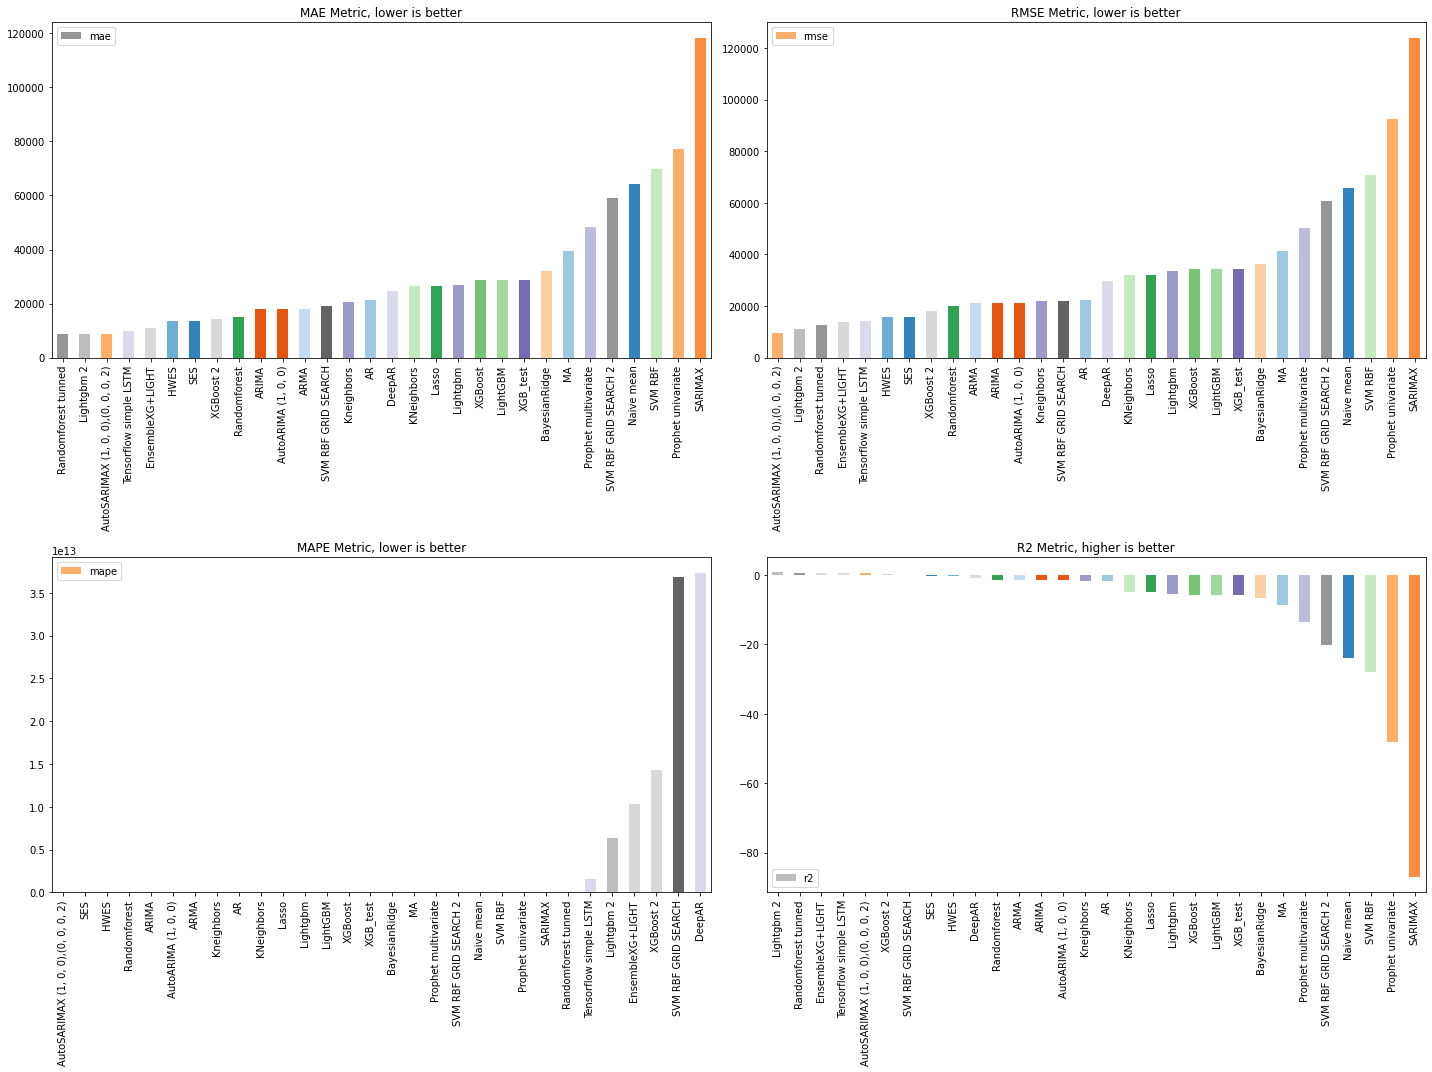

In [ ]:
bar_metrics(resultsDict)

In [ ]:
my_predictions

{'Lightgbm 2': array([ 2562.65521538, 26027.10954604, 57639.3728347 , 61576.5085816 ,
        60299.74433186, 54442.97652012, 38909.69053675,  3397.43752882,
        25572.78997286, 52425.00660533, 50510.27685727, 48305.25108834,
        48597.0006058 , 39221.67426012,  -865.45709249, 22975.51172581,
        55391.17324788, 62363.6961076 , 52467.98190052, 75623.70171055,
        57525.33383008, 11052.75790651, 29668.94684571, 68223.01872042,
        68657.15493885, 70536.66626345, 66199.68214908, 43188.9235504 ]),
 'Tensorflow simple LSTM': array([  -96.47632, 30348.607  , 42192.234  , 42536.863  , 42652.27   ,
        43354.3    , 40065.152  ,   854.7033 , 29984.857  , 40705.016  ,
        41517.83   , 41985.203  , 42131.23   , 42323.133  ,   547.0996 ,
        33377.332  , 40232.457  , 40745.477  , 40772.406  , 43043.84   ,
        43319.504  ,  2884.5388 , 32664.97   , 42422.35   , 43366.324  ,
        43557.91   , 44395.17   , 45196.707  ], dtype=float32),
 'XGBoost 2': array([  63

In [ ]:
test_df

,Quantity,date,hour,dayofweek,quarter,month,year,dayofyear,sin_day,cos_day,dayofmonth,weekofyear
Date,,,,,,,,,,,,
2011-11-13,180316,2011-11-13,0,6,4,11,2011,317,0.296340,-0.955083,13,45
2011-11-20,150987,2011-11-20,0,6,4,11,2011,324,-0.404065,-0.914730,20,46
2011-11-27,146748,2011-11-27,0,6,4,11,2011,331,-0.905591,-0.424152,27,47
2011-12-04,153317,2011-12-04,0,6,4,12,2011,338,-0.961389,0.275192,4,48


In [ ]:
df_test

,Amount_Spent,date,hour,dayofweek,quarter,month,year,dayofyear,sin_day,cos_day,dayofmonth,weekofyear
Date,,,,,,,,,,,,
2011-11-12,0.00,2011-11-12,0,5,4,11,2011,316,0.963787,-0.266672,12,45
2011-11-13,29192.66,2011-11-13,0,6,4,11,2011,317,0.296340,-0.955083,13,45
2011-11-14,74546.77,2011-11-14,0,0,4,11,2011,318,-0.643561,-0.765395,14,46
2011-11-15,53090.36,2011-11-15,0,1,4,11,2011,319,-0.991775,0.127994,15,46
2011-11-16,47897.82,2011-11-16,0,2,4,11,2011,320,-0.428155,0.903705,16,46
2011-11-17,54839.12,2011-11-17,0,3,4,11,2011,321,0.529108,0.848554,17,46
2011-11-18,40542.11,2011-11-18,0,4,4,11,2011,322,0.999912,0.013247,18,46
2011-11-19,0.00,2011-11-19,0,5,4,11,2011,323,0.551402,-0.834240,19,46
2011-11-20,30236.18,2011-11-20,0,6,4,11,2011,324,-0.404065,-0.914730,20,46


In [ ]:
# Generate the aggregated weekly sales
# dated_retail_data = cleaned_data.copy()
df_test["Date"] = pd.to_datetime(df_test["date"]) - pd.to_timedelta(7, unit="d")
df_test.index = df_test["Date"]
#resampling to get the weekly sales and returns
weekly_sale_test = df_test[df_test['Amount_Spent']>0].Amount_Spent.resample('W').sum()
# weekly_retail = dated_retail_data[dated_retail_data['Quantity']<0].Quantity.resample('W').sum().abs()

In [ ]:
weekly_sale_test

Date
2011-11-06     29192.66
2011-11-13    301152.36
2011-11-20    250876.68
2011-11-27    253755.66
2011-12-04    286089.64
Freq: W-SUN, Name: Amount_Spent, dtype: float64

In [ ]:
xgboost_pred = predictionsDict["XGBoost 2"]

xg_boost = pd.DataFrame(xgboost_pred,columns=["Amount_Spent"])
xg_boost.index = df_test.index

In [ ]:
xg_boost

,Amount_Spent
Date,
2011-11-05,6395.382812
2011-11-06,26448.267578
2011-11-07,59023.191406
2011-11-08,66680.125000
2011-11-09,59674.597656
2011-11-10,58064.605469
2011-11-11,27729.171875
2011-11-12,8699.610352
2011-11-13,31062.460938


In [ ]:
weekly_xg_boost = xg_boost[xg_boost['Amount_Spent']>0].Amount_Spent.resample('W').sum()

In [ ]:
weekly_xg_boost

Date
2011-11-06     32843.648438
2011-11-13    310933.750000
2011-11-20    264979.843750
2011-11-27    374287.406250
2011-12-04    398007.968750
Freq: W-SUN, Name: Amount_Spent, dtype: float32

In [ ]:
evaluate(weekly_sale_test.values,
         weekly_xg_boost.values)

{'mae': 51997.12343750037,
 'mape': 0.2159904517667238,
 'r2': 0.4457308209189358,
 'rmse': 73975.0210529609}